Two high-level analyses:
- Predict performance (accuracy) using a regression
- Classify users into 'bad' vs 'good'--still need to define this but perhaps the threshold is any user < 70% and any user >= 70%

For github issues and brainstorming features and analyses, use github:
- https://github.com/ProjectSidewalk/sidewalk-quality-analysis/issues

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from dateutil.parser import parse
import parse as str_parse
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.decomposition import PCA
# from umap import UMAP
import seaborn as sns
users = pd.read_csv('ml-users.csv') 
%matplotlib notebook

In [2]:
df_interactions = pd.read_csv('ml-interactions.tar.gz', compression='gzip') # load the full gzip tarball
#interactions = pd.read_csv('ml-interactions15000.csv')
#display(df_interactions.head())

# Do a little cleanup...
# In my initial analysis, i found that at least one row has a NaN value for an 'action' field. This should
# not happen. So, let's find that row (and others) that have this problem and remove them

# pd.isna checks for missing values (NaN values). It returns a boolean array where the index corresponds to
# row and the value corresponds to True/False indicating whether there is a NaN value
isna_result = pd.isna(df_interactions['action'])
df_interactions= df_interactions[~isna_result] # we want all rows where isna is False (that is, all rows *without* a NaN for 'action')
# As a test, we can again look for NaN 'action' cells
isna_result = pd.isna(df_interactions['action'])
assert sum(df_interactions['action'].isna()) == 0

df_interactions.rename(columns = {'ml-interactions.csv':'timestamp'}, inplace = True)

In [230]:
# df_interactions.head()

In [4]:
def scatter(series, name, ax=None, px=True, py=True):
    if ax is None:
        fig, ax = plt.subplots()
        
    if px:
        ax.set_xlabel(name)
        
    if py:
        ax.set_ylabel('accuracy')
        
    slope, intercept, r_value, p_value, std_err = stats.linregress(series, users[' accuracy'])
    p = np.poly1d([slope, intercept])
    ax.plot(series, p(series), 'r--')
    ax.scatter(series, users[' accuracy'])

## Analysis of users

In [5]:
users = users.set_index('user_id')

In [229]:
# users.head()

(array([1., 0., 0., 0., 1., 1., 1., 3., 4., 5.]),
 array([38.49765258, 43.10300215, 47.70835171, 52.31370128, 56.91905084,
        61.5244004 , 66.12974997, 70.73509953, 75.3404491 , 79.94579866,
        84.55114823]),
 <a list of 10 Patch objects>)

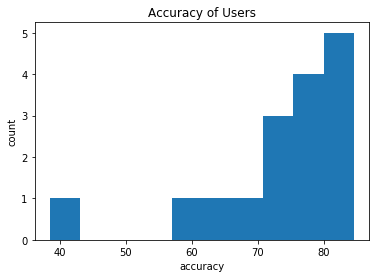

In [7]:
plt.figure()
plt.title('Accuracy of Users')
plt.xlabel('accuracy')
plt.ylabel('count')
plt.hist(users[' accuracy'])

### Misc. analysis

In [ ]:
def func(x):
    return xyz


gr.apply(func)
gr.apply(lambda x: xyz)

In [8]:
keyboard_counts = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'].isin(['LowLevelEvent_keydown', 'KeyboardShortcut_ModeSwitch_NoSidewalk'])))


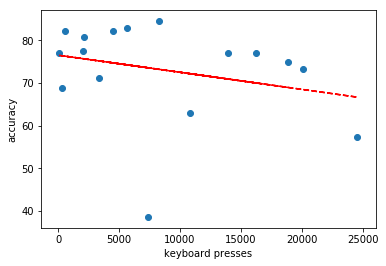

In [9]:
scatter(keyboard_counts, 'keyboard presses')

In [10]:
num_missions = df_interactions.groupby('user_id').apply(lambda x: sum(x['action']=='MissionComplete'))

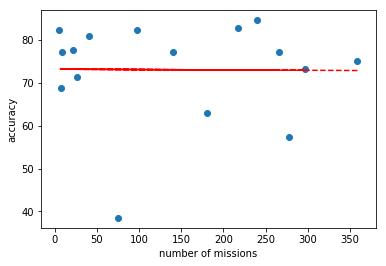

In [11]:
scatter(num_missions, 'number of missions')

In [12]:
keyboard_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'].isin(['LowLevelEvent_keydown', 'KeyboardShortcut_ModeSwitch_NoSidewalk'])) / x['gsv_panorama_id'].unique().size)

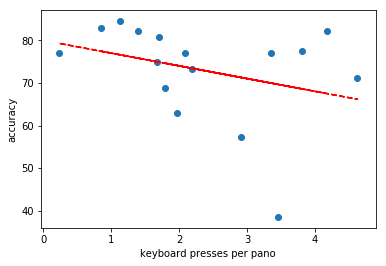

In [13]:
scatter(keyboard_per_pano, 'keyboard presses per pano')

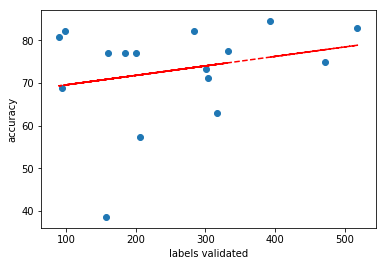

In [14]:
scatter(users[' labels_validated'], 'labels validated')

In [15]:
pov_per_panorama = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'POV_Changed') / x['gsv_panorama_id'].size)

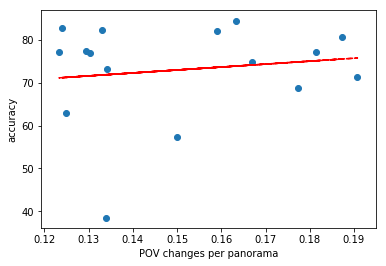

In [16]:
scatter(pov_per_panorama, 'POV changes per panorama')

In [17]:
avg_zoom = df_interactions.groupby('user_id').apply(lambda x: x['zoom'].mean())

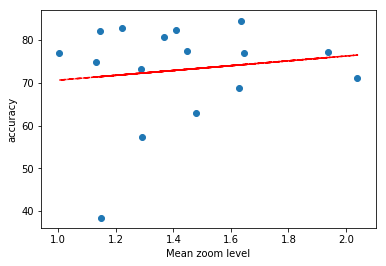

In [18]:
scatter(avg_zoom, 'Mean zoom level')

In [19]:
mouse_moves_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_mousemove') / x['gsv_panorama_id'].unique().size)

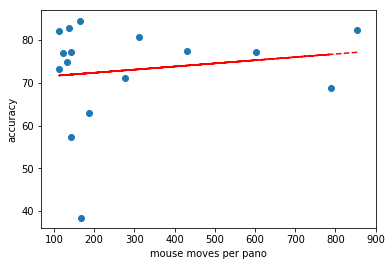

In [20]:
scatter(mouse_moves_per_pano, 'mouse moves per pano')

### Comparison of two features

In [21]:
clicks_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['action'] == 'LowLevelEvent_click') / x['gsv_panorama_id'].unique().size)
up_key_per_pano = df_interactions.groupby('user_id').apply(lambda x: sum(x['note'] == 'keyCode:38') / x['gsv_panorama_id'].unique().size)

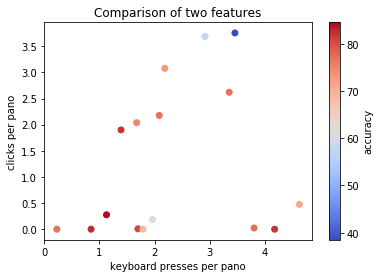

In [22]:
fig, ax = plt.subplots()
ax.set_title('Comparison of two features')
ax.set_xlabel('keyboard presses per pano')
ax.set_ylabel('clicks per pano')
sc = ax.scatter(keyboard_per_pano, up_key_per_pano, c=users[' accuracy'], cmap='coolwarm')
cbar = plt.colorbar(sc)
cbar.set_label('accuracy')

### Time between labeling and last POV_Changed 

In [23]:
def times_between_pov_change_and_label(u):
    pov_changed = u[u['action']=='POV_Changed']['timestamp'].apply(lambda x: parse(x)).sort_values()
    finish_labeling = u[u['action'] == 'LabelingCanvas_FinishLabeling']['timestamp'].apply(lambda x: parse(x))
    time_sec = np.array([(finish_labeling.iloc[index] - pov_changed.iloc[pov_changed.searchsorted(finish_labeling.iloc[index]) - 1]).total_seconds() for index in range(finish_labeling.size)])
    return time_sec

In [24]:
u = df_interactions[df_interactions['user_id'] == 'e4ff325c-309b-4ea6-8555-8f973e662362']
time_sec = times_between_pov_change_and_label(u)

Text(0, 0.5, 'count')

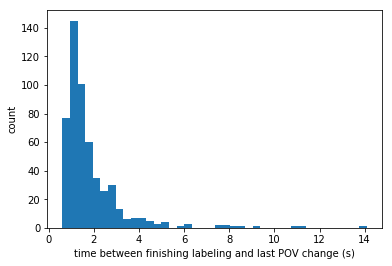

In [25]:
plt.figure()
plt.hist(time_sec, bins=40)
plt.xlabel('time between finishing labeling and last POV change (s)')
plt.ylabel('count')

In [26]:
med_time_pov_label = df_interactions.groupby('user_id').apply(lambda x: np.mean(times_between_pov_change_and_label(x)))

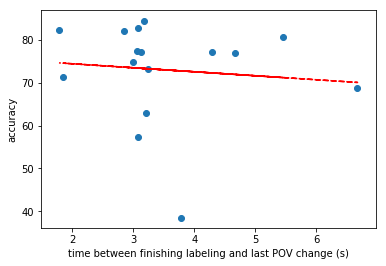

In [27]:
scatter(med_time_pov_label, 'time between finishing labeling and last POV change (s)')

## Amount of pano seen

In [28]:
u = df_interactions[df_interactions['user_id'] == 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b'].sort_values('timestamp')

In [29]:
# k = u[(u['gsv_panorama_id'] == 'yswXpbti65Rk8pcuuB5IAQ') & (u['action'] == 'POV_Changed')]
k = u[(u['gsv_panorama_id'] == 'CLoDdiJDFuIOL8E9ggE_Bw') & (u['action'] == 'POV_Changed')]

In [30]:
timestamps = k['timestamp'].apply(lambda x: parse(x))
timedeltas = (timestamps - timestamps.iloc[0]).apply(lambda x: x.total_seconds())
headings = k['heading']

In [31]:
def normalize_headings(heading_list):
    start_heading = heading_list.iloc[0]
    h = heading_list - start_heading
    h[h > 180] = h[h > 180] - 360
    return h

def range_headings(heading_list):
    norm = normalize_headings(heading_list)
    return pd.Series({'min': np.min(norm), 'max': np.max(norm)})

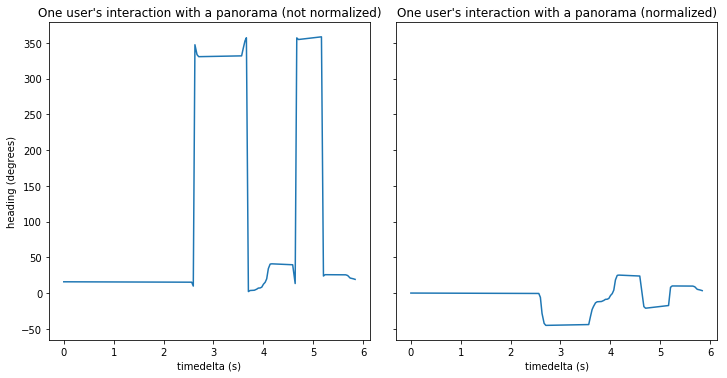

In [32]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))
fig.tight_layout()
ax[0].set_title('One user\'s interaction with a panorama (not normalized)')
ax[0].set_ylabel('heading (degrees)')
ax[0].set_xlabel('timedelta (s)')
ax[0].plot(timedeltas, headings)

ax[1].set_title('One user\'s interaction with a panorama (normalized)')
ax[1].set_xlabel('timedelta (s)')
ax[1].plot(timedeltas, normalize_headings(headings))

Let's assume that the range of seen positions is between the min normalized heading and the max normalized heading.

In [33]:
u_pov = u[u['action'] == 'POV_Changed']
seen_range = u_pov.groupby('gsv_panorama_id').apply(lambda x: range_headings(x['heading']))

(array([1.940e+02, 6.500e+01, 3.000e+01, 1.200e+01, 8.000e+00, 7.000e+00,
        1.000e+01, 1.600e+01, 2.300e+01, 8.000e+00, 3.000e+00, 8.000e+00,
        6.000e+00, 1.000e+00, 1.300e+01, 4.000e+01, 1.300e+01, 1.300e+01,
        2.000e+01, 3.000e+01, 2.900e+01, 2.900e+01, 5.400e+01, 8.600e+01,
        1.090e+02, 1.390e+02, 1.880e+02, 2.570e+02, 3.500e+02, 2.384e+03]),
 array([-359.82143293, -347.82738517, -335.8333374 , -323.83928964,
        -311.84524187, -299.85119411, -287.85714634, -275.86309858,
        -263.86905081, -251.87500305, -239.88095529, -227.88690752,
        -215.89285976, -203.89881199, -191.90476423, -179.91071646,
        -167.9166687 , -155.92262094, -143.92857317, -131.93452541,
        -119.94047764, -107.94642988,  -95.95238211,  -83.95833435,
         -71.96428659,  -59.97023882,  -47.97619106,  -35.98214329,
         -23.98809553,  -11.99404776,    0.        ]),
 <a list of 30 Patch objects>)

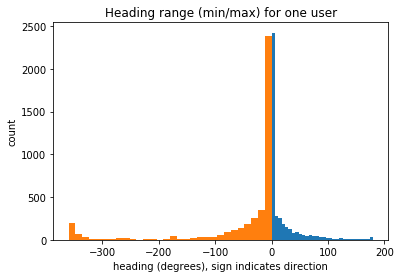

In [34]:
plt.figure()
plt.title('Heading range (min/max) for one user')
plt.xlabel('heading (degrees), sign indicates direction')
plt.ylabel('count')
plt.hist(seen_range['max'], bins=30)
plt.hist(seen_range['min'], bins=30)

(array([1820.,  389.,  280.,  225.,  161.,  158.,  122.,   85.,   75.,
          78.,   64.,   56.,   37.,   44.,   31.,   27.,   16.,   18.,
          19.,   12.,   10.,   10.,    4.,    6.,    2.,    0.,    4.,
           9.,   32.,  351.]),
 array([  0.        ,  11.99702425,  23.99404849,  35.99107274,
         47.98809698,  59.98512123,  71.98214547,  83.97916972,
         95.97619396, 107.97321821, 119.97024246, 131.9672667 ,
        143.96429095, 155.96131519, 167.95833944, 179.95536368,
        191.95238793, 203.94941217, 215.94643642, 227.94346067,
        239.94048491, 251.93750916, 263.9345334 , 275.93155765,
        287.92858189, 299.92560614, 311.92263038, 323.91965463,
        335.91667888, 347.91370312, 359.91072737]),
 <a list of 30 Patch objects>)

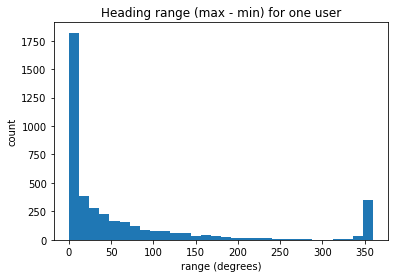

In [35]:
plt.figure()
plt.title('Heading range (max - min) for one user')
plt.xlabel('range (degrees)')
plt.ylabel('count')
plt.hist(seen_range['max'] - seen_range['min'], bins=30)

In [36]:
def get_mean_heading_range(x):
    x_pov = x[x['action'] == 'POV_Changed']
    seen_range = x_pov.groupby('gsv_panorama_id').apply(lambda y: range_headings(y['heading']))
    return np.mean(seen_range['max'] - seen_range['min'])

In [37]:
mean_heading_range = df_interactions.groupby('user_id').apply(lambda x: get_mean_heading_range(x))

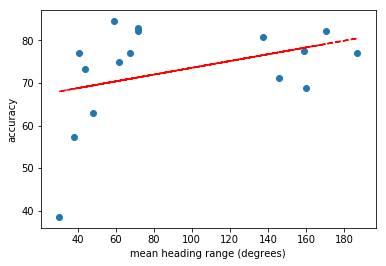

In [38]:
scatter(mean_heading_range, 'mean heading range (degrees)')

## Heatmaps

Where labels are on the canvas

In [39]:
def get_canvas_coordinates(row):
    result = str_parse.search('canvasX:{:d},canvasY:{:d}', row)
    return pd.Series({'x': result[0], 'y': result[1]})

In [40]:
coords = df_interactions[df_interactions['action'] == 'LabelingCanvas_FinishLabeling']['note'].apply(get_canvas_coordinates)


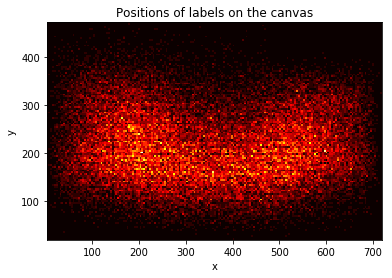

In [41]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Positions of labels on the canvas')
plt.hist2d(coords.x, coords.y, bins=(180, 120), cmap='hot')
plt.show()

## Going in Reverse

Going in reverse is defined as going to one pano, then another, then back to the first pano.

In [42]:
u = df_interactions[df_interactions['user_id'] == 'bf16418a-4c99-4fd6-99c6-7e8b40fbe17b'].sort_values('timestamp')

In [43]:
def get_reverse_freq(x):
    pano_changed = x[x['action'] == 'PanoId_Changed']['gsv_panorama_id']
    count = 0
    for i in range(2, pano_changed.size):
        if (pano_changed.iloc[i] != pano_changed.iloc[i-1] and
            pano_changed.iloc[i] in [pano_changed.iloc[i-k] for k in range(1,10)]):
                count += 1
    return count / pano_changed.size

In [44]:
get_reverse_freq(u)

0.08155136268343816

In [45]:
going_in_reverse = df_interactions.groupby('user_id').apply(get_reverse_freq)

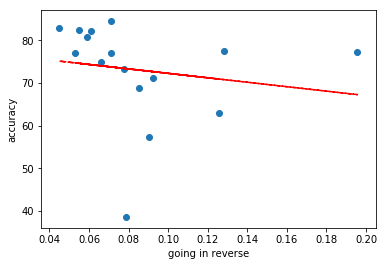

In [46]:
scatter(going_in_reverse, 'going in reverse')

#### Crude test of predicting accuracy

TODO: Run through the whole ML pipeline

In [139]:
val_mat = np.stack((mouse_moves_per_pano, clicks_per_pano, keyboard_per_pano, num_missions, avg_zoom, up_key_per_pano, med_time_pov_label, mean_heading_range, going_in_reverse))

In [140]:
# We need to normalize these labels. For now, scale them so the max is 1 and the min is 0
for i in range(val_mat.shape[0]):
    val_mat[i] = (val_mat[i] - val_mat[i].min()) / val_mat[i].max()

In [141]:
# sort the matrixascending by accuracy
val_mat = val_mat.T[np.argsort(users[' accuracy'].values)]

<IPython.core.display.Javascript object>


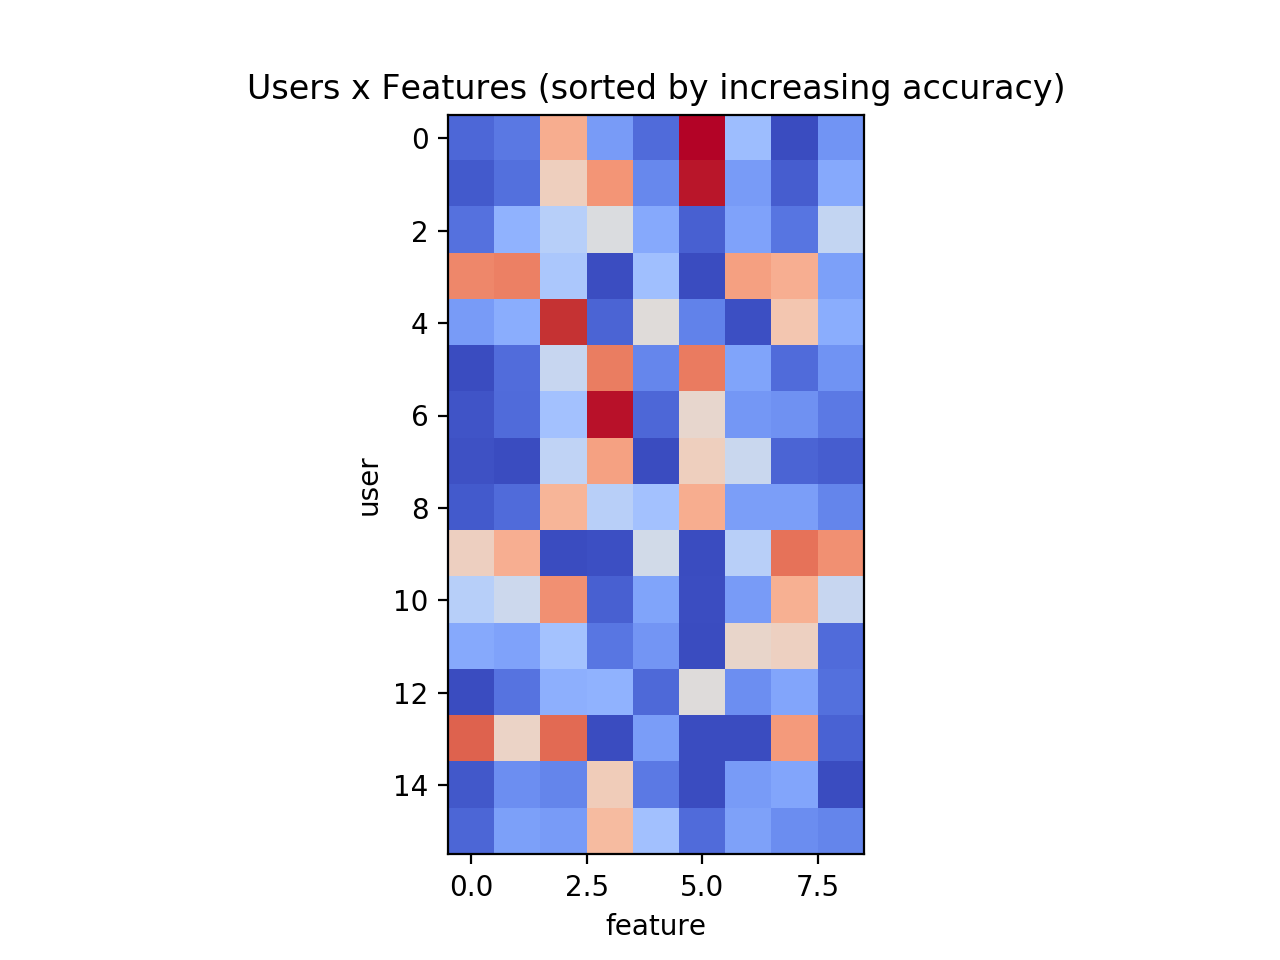

In [223]:
plt.figure()
plt.title('Users x Features (sorted by increasing accuracy)')
plt.xlabel('feature')
plt.ylabel('user')
plt.imshow(val_mat, cmap='coolwarm')

In [78]:
accuracy_sorted = np.sort(users[' accuracy'].values)

In [224]:
X_train, X_test, y_train, y_test = train_test_split(val_mat, accuracy_sorted, test_size=0.2)

In [225]:
regr = ensemble.RandomForestRegressor(n_estimators=100)

In [226]:
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [227]:
regr.predict(X_test)

array([78.24450969, 81.95110596, 81.36105694, 76.22728804])

In [228]:
y_test

array([77.09251101, 82.81786942, 74.95559503, 68.88111888])

<IPython.core.display.Javascript object>


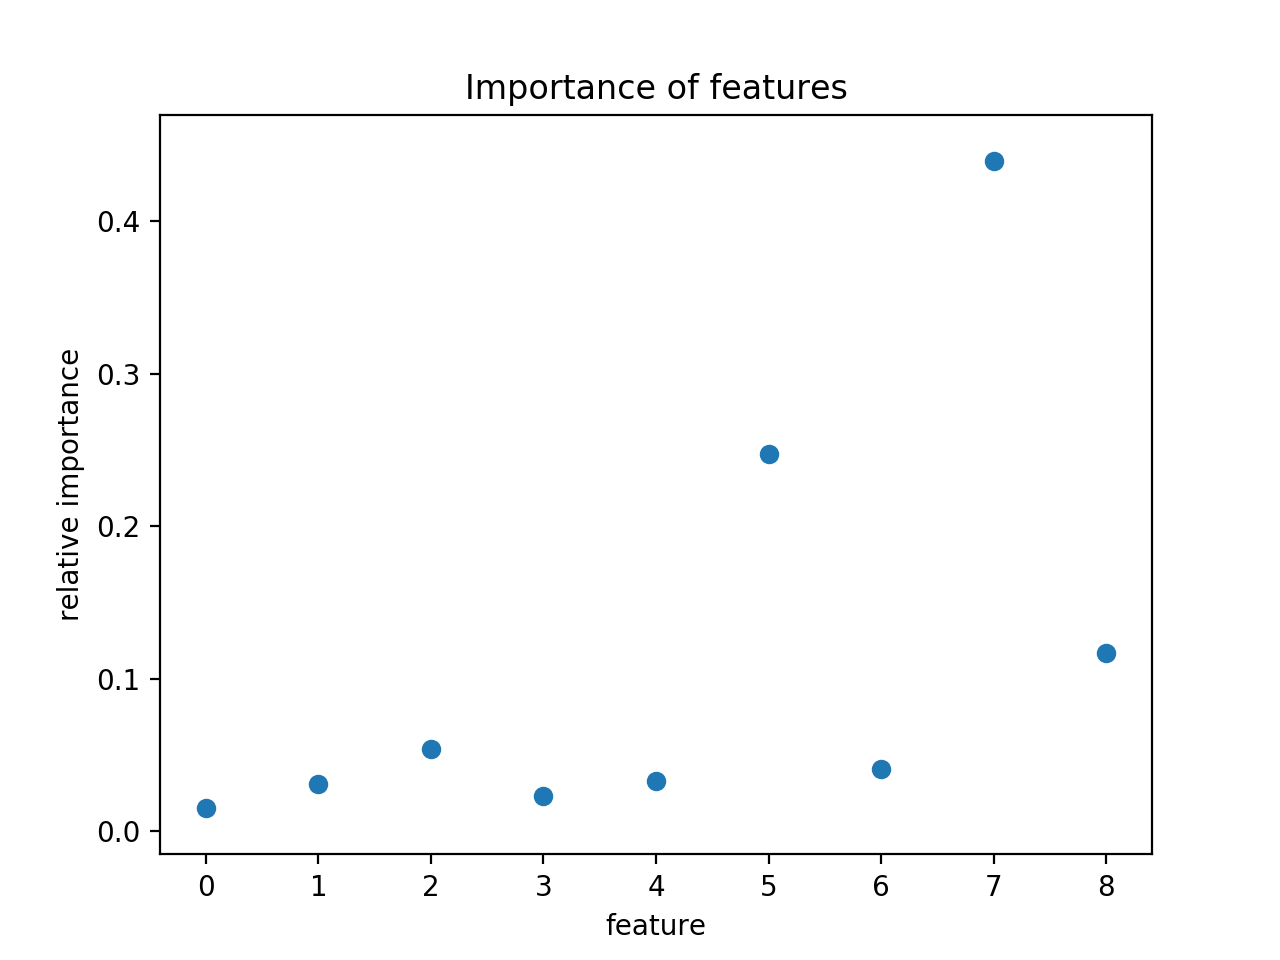

In [203]:
plt.figure()
plt.xlabel('feature')
plt.ylabel('relative importance')
plt.title('Importance of features')
plt.scatter(range(val_mat.shape[1]), regr.feature_importances_)

<IPython.core.display.Javascript object>


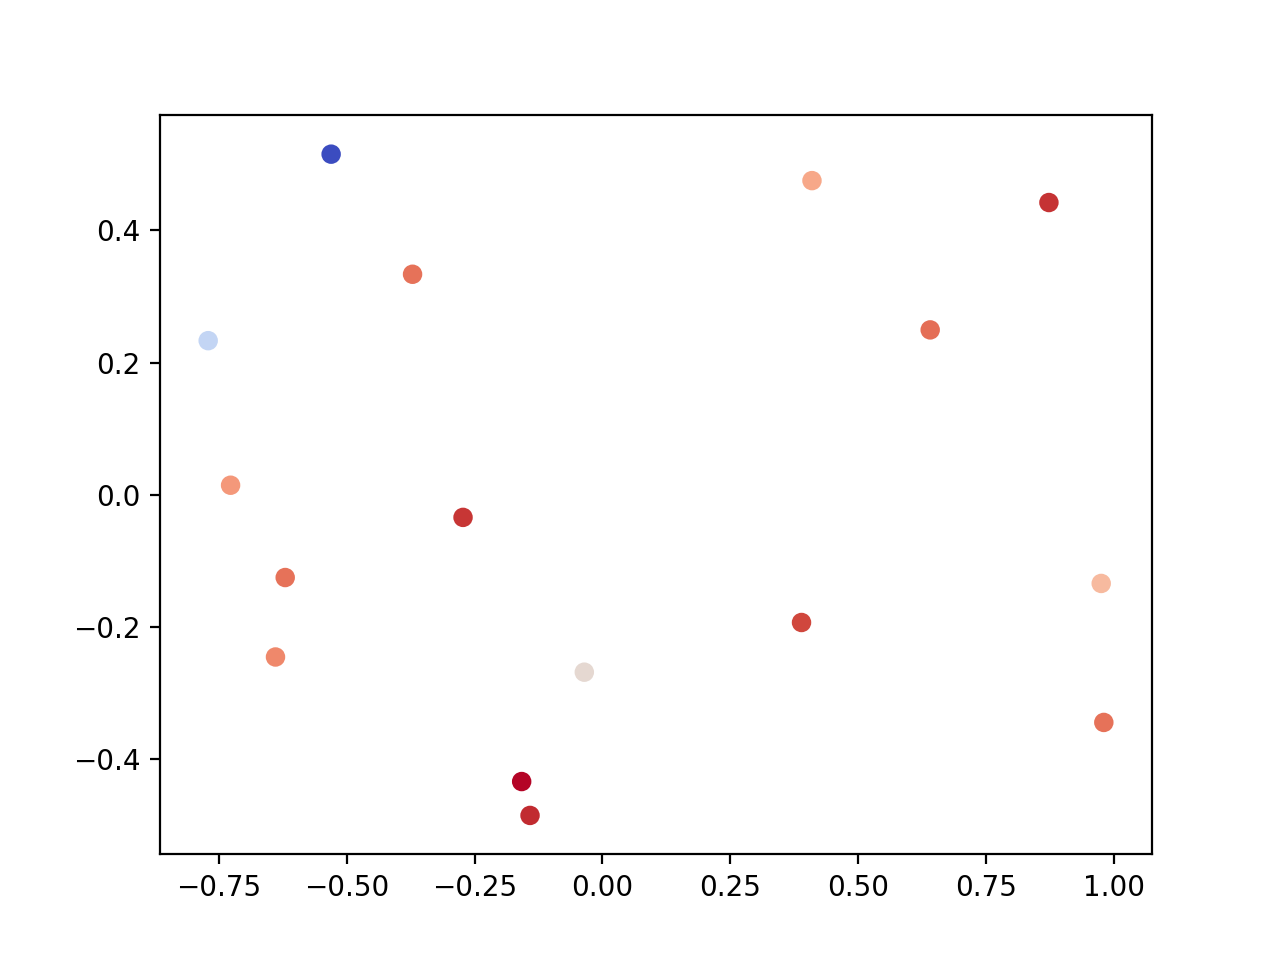

In [149]:
pca = PCA(n_components=2).fit_transform(val_mat)
plt.figure()
plt.scatter(pca[:, 0], pca[:, 1], c=accuracy_sorted, cmap='coolwarm')

In [204]:
# vm_2 = umap.UMAP(n_components=2, min_dist=0).fit_transform(val_mat)

In [205]:
# plt.figure()
# plt.scatter(vm_2[:, 0], vm_2[:, 1], c=accuracy_sorted, cmap='coolwarm')

## Scatter Matrix

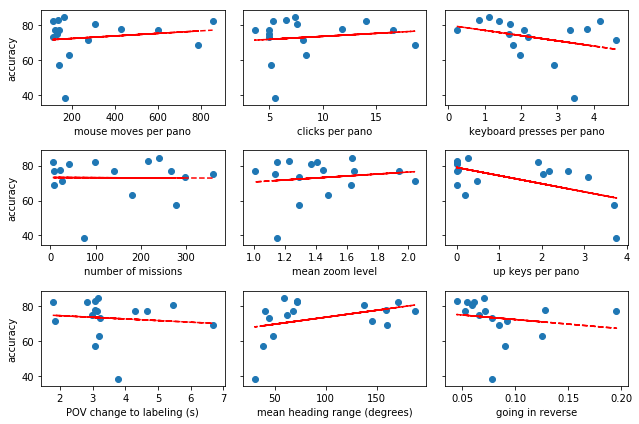

In [48]:
fig, ax = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(9, 6))
scatter(mouse_moves_per_pano, 'mouse moves per pano', ax=ax[0][0])
scatter(clicks_per_pano, 'clicks per pano', ax=ax[0][1], py=False)
scatter(keyboard_per_pano, 'keyboard presses per pano', ax=ax[0][2], py=False)
scatter(num_missions, 'number of missions', ax=ax[1][0])
scatter(avg_zoom, 'mean zoom level', ax=ax[1][1], py=False)
scatter(up_key_per_pano, 'up keys per pano', ax=ax[1][2], py=False)
scatter(med_time_pov_label, 'POV change to labeling (s)', ax=ax[2][0])
scatter(mean_heading_range, 'mean heading range (degrees)', ax=ax[2][1], py=False)
scatter(going_in_reverse, 'going in reverse', ax=ax[2][2], py=False)
fig.tight_layout()

## Correlation Matrix

In [197]:
column_headers = ['mouse moves per pano', 'clicks per pano', 'keyboard presses per pano', 
                  'number of missions', 'mean zoom level', 'up keys per pano', 
                 'POV change to labeling (s)', 'mean heading range (deg)', 'going in reverse']
list_of_feature_vectors = np.array([mouse_moves_per_pano.values, clicks_per_pano.values, keyboard_per_pano.values, num_missions.values, avg_zoom.values, up_key_per_pano.values, med_time_pov_label.values, mean_heading_range.values, going_in_reverse.values]).T

In [201]:
df_features = pd.DataFrame(list_of_feature_vectors, columns=column_headers)

<IPython.core.display.Javascript object>


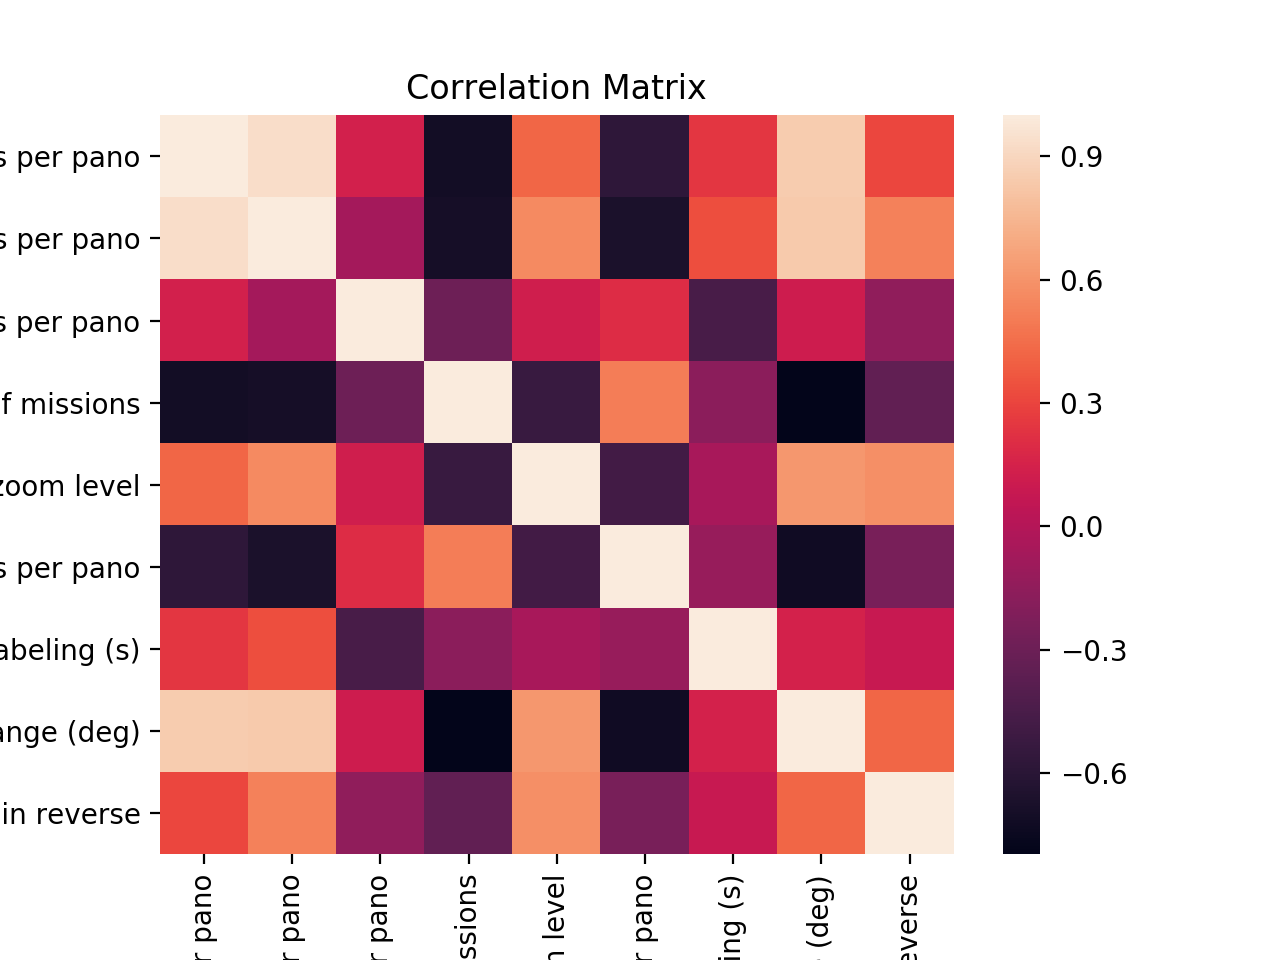

In [212]:
plt.figure()
plt.title('Correlation Matrix')
sns.heatmap(df_features.corr())

<IPython.core.display.Javascript object>


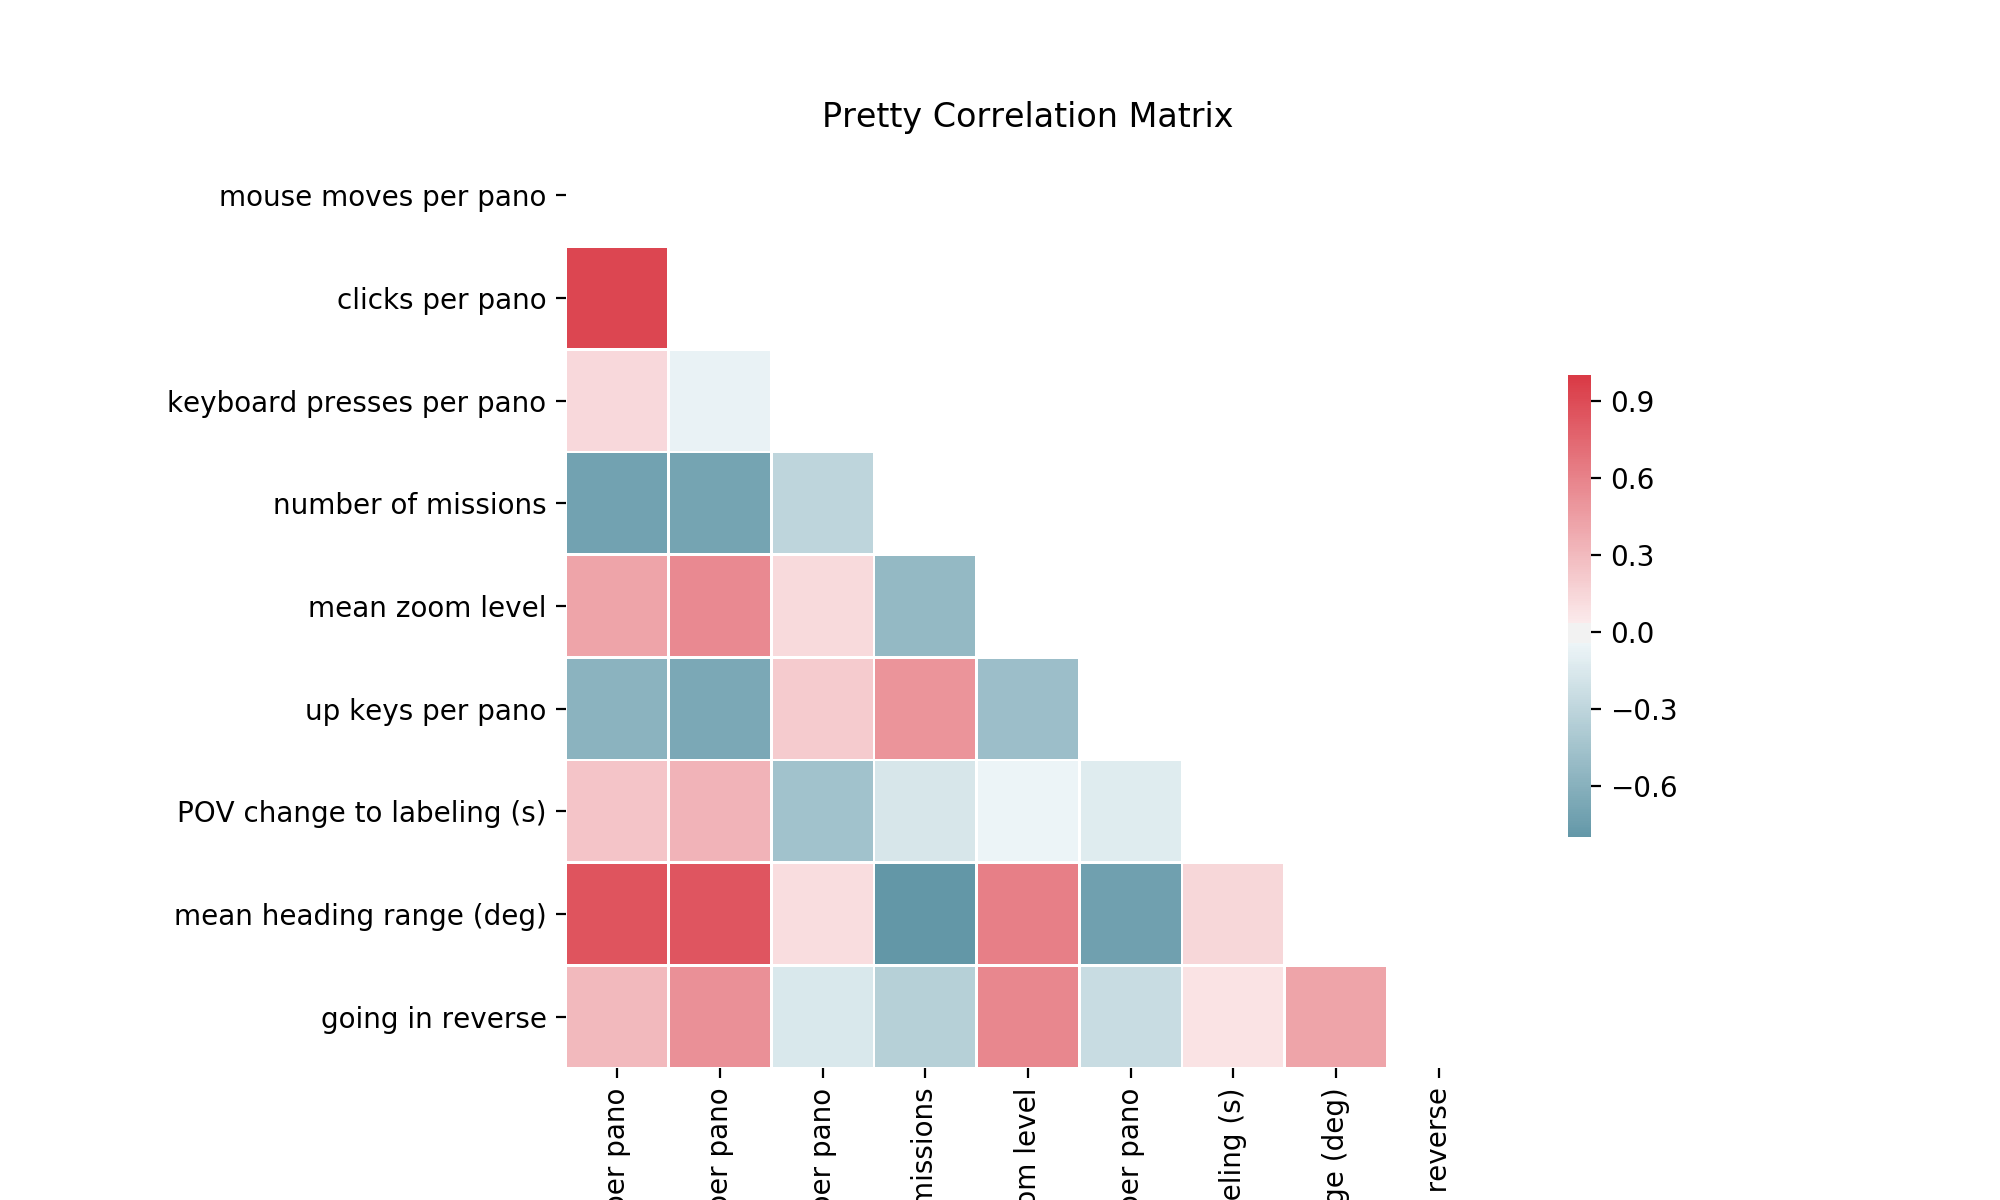

In [221]:
# Compute the correlation matrix
corr = df_features.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from (mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))
ax.set_title('Pretty Correlation Matrix')
# Generate a custom diverging colormap
cmap = sns.diverging_palette (220, 10, as_cmap=True)
# Draw heatmap w/the mask & correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5,cbar_kws={"shrink":.5})

In [4]:
date1 = parse('4/25/2019  6:57:02 PM')

In [5]:
date2 = parse('4/25/2019  7:37:02.1 PM')

In [7]:
(date2-date1).total_seconds()

2400.1